In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import psycopg2
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import datetime
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from keras.callbacks import History
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import MeanAbsoluteError

In [2]:
# Connect to PostgreSQL database
conn = psycopg2.connect(
    dbname="manga_db",
    user="user_master",
    password="PassMaster97",
    host="localhost",
    port="5432"
)
cur = conn.cursor()

In [3]:
# Load data from the database
mangas_base = pd.read_sql_query("SELECT * FROM mangas_base", conn)
mangas_extra = pd.read_sql_query("SELECT * FROM mangas_extra", conn)

/var/folders/1f/nl9h7sjs4617dm270zv75gq80000gn/T/ipykernel_56374/3018586137.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  mangas_base = pd.read_sql_query("SELECT * FROM mangas_base", conn)
/var/folders/1f/nl9h7sjs4617dm270zv75gq80000gn/T/ipykernel_56374/3018586137.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  mangas_extra = pd.read_sql_query("SELECT * FROM mangas_extra", conn)


In [4]:
# Merge both tables
df = pd.merge(mangas_base, mangas_extra, left_on="id", right_on="id_manga", how="left")
df

,id_x,title,original_title,script,artist,ed_japanese,demography,num_japanese,num_korean,synopsis_es,...,synopsis,id_y,id_manga,tags,start_date,end_date,status,average_score,popularity,mean_score
0,154975,Black Yome ni Yoroshiku!,ブラック嫁によろしく！,Maruboro Akai,Maruboro Akai,None,None,1.0,NaN,None,...,"Shinta, a normal highschooler on his way to sc...",140267.0,154975.0,[Shounen],2013-07-09,2014-06-09,CANCELLED,58.0,464.0,68.0
1,154976,Hajime no Ippo,はじめの一歩,George Morikawa,George Morikawa,None,None,NaN,NaN,None,...,Makunouchi Ippo has been bullied his entire li...,140268.0,154976.0,"[Boxing, Shounen, Male Protagonist, Primarily ...",1989-09-27,None,RELEASING,87.0,29465.0,87.0
2,154977,NARUTO,NARUTO -ナルト-,Masashi Kishimoto,Masashi Kishimoto,None,None,72.0,NaN,None,...,"Before Naruto's birth, a great demon fox had a...",140269.0,154977.0,"[Shounen, Ninja, Coming of Age, Revenge, Super...",1999-09-21,2014-11-10,FINISHED,79.0,85606.0,79.0
3,154978,BLEACH,BLEACH,Tite Kubo,Tite Kubo,None,None,74.0,NaN,None,...,Ichigo Kurosaki has always been able to see gh...,140270.0,154978.0,"[Shounen, Swordplay, Super Power, Ghost, Male ...",2001-08-07,2016-08-23,FINISHED,79.0,101182.0,79.0
4,154979,Groove Adventure Rave,レイヴ,Hiro Mashima,Hiro Mashima,None,None,35.0,NaN,None,...,The Continent of Song is in chaos. The siniste...,140271.0,154979.0,"[Shounen, Male Protagonist, Time Manipulation,...",1999-07-07,2005-07-27,FINISHED,75.0,10098.0,75.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63227,114093,El patito feo que surcó los cielos,宇宙を駆けるよだか,Shiki Kawabata,Shiki Kawabata,Shueisha,Shoujo,3.0,NaN,"El día que debía ser el más feliz de su vida, ...",...,The day she was supposed to be the happiest of...,99396.0,114093.0,"[School, Shoujo, Love Triangle, Tragedy, Body ...",2014-09-13,2015-11-13,FINISHED,64.0,1577.0,66.0
63228,114130,La Balada del Viento y los Árboles,風と木の詩,Keiko Takemiya,Keiko Takemiya,Hakusensha,Shoujo,10.0,NaN,"Arlés, finales del siglo XIX. \n \r\nSerge Bat...",...,"Arlés, late 19th century. Serge Battour is the...",99433.0,114130.0,"[Boys' Love, Tragedy, Historical, Coming of Ag...",1976-02-29,1984-06-01,FINISHED,76.0,4445.0,79.0
63229,114132,La boda de las luciérnagas,ホタルの嫁入り,Oreco Tachibana,Oreco Tachibana,Shogakukan,Shoujo,7.0,NaN,Era Meiji. Satoko Kirigaya es bella y pertenec...,...,It was Meiji. Satoko Kirigaya is beautiful and...,99435.0,114132.0,"[Yandere, Heterosexual, Josei, Female Protagon...",2023-01-01,None,RELEASING,79.0,12017.0,80.0
63230,114159,Mis memorandos sobre la bruja,僕と魔女についての備忘録,Yuu Mitsuha,Yuu Mitsuha,Shogakukan,Shoujo,5.0,NaN,Wataru era un niño pequeño cuando se perdió en...,...,Wataru was a little boy when he got lost in th...,99462.0,114159.0,"[Witch, Age Gap, Shoujo, Magic, Heterosexual]",2020-01-29,2022-08-24,FINISHED,NaN,243.0,81.0


In [5]:
# Select relevant columns
df_features = df[[
    "id_x", "script", "artist", "ed_japanese", "demography", "num_japanese",
    "num_korean", "country_origin", "start_date", "end_date", "status",
    "average_score", "popularity", "mean_score"
]]
df_features = df_features.rename(columns={"id_x": "manga_id"})

In [6]:
# Convert dates to years and duration
df_features["start_year"] = pd.to_datetime(df_features["start_date"], errors="coerce").dt.year
df_features["end_year"] = pd.to_datetime(df_features["end_date"], errors="coerce").dt.year
df_features["duration"] = df_features["end_year"] - df_features["start_year"]

df_features = df_features.drop(columns=["start_date", "end_date"])

In [7]:
# Separate column types
categorical_cols = ["script", "artist", "ed_japanese", "demography", "country_origin", "status"]
numerical_cols = ["num_japanese", "num_korean", "average_score", "popularity", "mean_score", "start_year", "end_year", "duration"]

In [8]:
# Preprocessing pipeline
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numerical_cols),
    ("cat", categorical_pipeline, categorical_cols)
])


In [9]:
X = preprocessor.fit_transform(df_features)

In [10]:
# Build the autoencoder
input_dim = X.shape[1]
encoding_dim = 32
reg_strength = 1e-4

In [11]:
input_layer = Input(shape=(input_dim,))

# Encoder
x = Dense(24, activation="relu", kernel_regularizer=l2(reg_strength))(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

x = Dense(28, activation="relu", kernel_regularizer=l2(reg_strength))(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

In [12]:
encoded = Dense(encoding_dim, activation="relu", kernel_regularizer=l2(reg_strength), name="encoder_output")(x)

# Decoder (para entrenamiento y reconstrucción)
x = Dense(28, activation="relu", kernel_regularizer=l2(reg_strength))(encoded)
x = BatchNormalization()(x)

x = Dense(24, activation="relu", kernel_regularizer=l2(reg_strength))(x)
x = BatchNormalization()(x)

output_layer = Dense(input_dim, activation="linear")(x)

In [13]:
autoencoder = Model(inputs=input_layer, outputs=output_layer)
encoder = Model(inputs=input_layer, outputs=encoded)

In [14]:
optimizer = Adam(learning_rate=0.001)
autoencoder.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

In [15]:
# 4. Callbacks para mejorar el entrenamiento
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_autoencoder.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [16]:
# Compile the autoencoder
autoencoder.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="mse",
    metrics=["mse", MeanAbsoluteError(name="mae")]
)


In [17]:
# Train the autoencoder
history = autoencoder.fit(
    X, X,
    epochs=100,
    batch_size=32,
    shuffle=True,
    validation_split=0.2,
    callbacks=[reduce_lr, early_stopping, checkpoint],
    verbose=1
)

Epoch 1/100
1581/1581 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - mae: 0.0024 - mse: 2.2295e-04
Epoch 1: val_loss improved from inf to 0.00037, saving model to best_autoencoder.h5


1581/1581 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 0.0027 - mae: 0.0024 - mse: 2.2290e-04 - val_loss: 3.6500e-04 - val_mae: 7.0183e-04 - val_mse: 3.2596e-04 - learning_rate: 0.0010
Epoch 2/100
1579/1581 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.6270e-04 - mae: 3.0632e-04 - mse: 1.2835e-04
Epoch 2: val_loss improved from 0.00037 to 0.00014, saving model to best_autoencoder.h5


1581/1581 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - loss: 1.6267e-04 - mae: 3.0631e-04 - mse: 1.2833e-04 - val_loss: 1.3583e-04 - val_mae: 3.8583e-04 - val_mse: 1.1166e-04 - learning_rate: 0.0010
Epoch 3/100
1579/1581 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.5548e-04 - mae: 2.9267e-04 - mse: 1.2644e-04
Epoch 3: val_loss did not improve from 0.00014
1581/1581 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - loss: 1.5546e-04 - mae: 2.9267e-04 - mse: 1.2642e-04 - val_loss: 1.9206e-04 - val_mae: 5.8225e-04 - val_mse: 1.6140e-04 - learning_rate: 0.0010
Epoch 4/100
1578/1581 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.5260e-04 - mae: 2.8389e-04 - mse: 1.2270e-04
Epoch 4: val_loss did not improve from 0.00014
1581/1581 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - loss: 1.5258e-04 - mae: 2.8388e-04 - mse: 1.2268e-04 - val_loss: 1.4089e-04 - val_mae: 4.1238e-04 - val_mse: 1.1485e-04 - learning_rate: 0.0010
Epoch 5/100
1581/1581 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3945e-04 - mae: 2.9205e-04 - mse: 1.0907e-04


1581/1581 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 1.3945e-04 - mae: 2.9204e-04 - mse: 1.0908e-04 - val_loss: 1.3196e-04 - val_mae: 3.5813e-04 - val_mse: 1.1143e-04 - learning_rate: 0.0010
Epoch 6/100
1579/1581 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4641e-04 - mae: 2.8378e-04 - mse: 1.1831e-04
Epoch 6: val_loss did not improve from 0.00013
1581/1581 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - loss: 1.4641e-04 - mae: 2.8377e-04 - mse: 1.1831e-04 - val_loss: 2.1870e-04 - val_mae: 6.4922e-04 - val_mse: 1.7878e-04 - learning_rate: 0.0010
Epoch 7/100
1580/1581 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2951e-04 - mae: 2.7873e-04 - mse: 1.0390e-04
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 7: val_loss did not improve from 0.00013
1581/1581 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - loss: 1.2953e-04 - mae: 2.7873e-04 - mse: 1.0391e-04 - val_loss: 5.7633e-04 - val_mae: 0.0013 - val_mse: 5.2525e-04 - learning_rate: 0.0010
Epoch 8/100
1581/1581 ━━━━━━━━━━━━━━━━

1581/1581 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 1.1362e-04 - mae: 2.3656e-04 - mse: 9.3619e-05 - val_loss: 1.2208e-04 - val_mae: 2.7595e-04 - val_mse: 1.0328e-04 - learning_rate: 5.0000e-04
Epoch 9/100
1580/1581 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3424e-04 - mae: 2.2282e-04 - mse: 1.1715e-04
Epoch 9: val_loss improved from 0.00012 to 0.00012, saving model to best_autoencoder.h5


1581/1581 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 1.3423e-04 - mae: 2.2282e-04 - mse: 1.1714e-04 - val_loss: 1.2159e-04 - val_mae: 2.7238e-04 - val_mse: 1.0451e-04 - learning_rate: 5.0000e-04
Epoch 10/100
1580/1581 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1384e-04 - mae: 2.2303e-04 - mse: 9.6035e-05
Epoch 10: val_loss improved from 0.00012 to 0.00011, saving model to best_autoencoder.h5


1581/1581 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 1.1385e-04 - mae: 2.2303e-04 - mse: 9.6049e-05 - val_loss: 1.1307e-04 - val_mae: 2.6728e-04 - val_mse: 9.6541e-05 - learning_rate: 5.0000e-04
Epoch 11/100
1578/1581 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2046e-04 - mae: 2.1943e-04 - mse: 1.0283e-04
Epoch 11: val_loss did not improve from 0.00011
1581/1581 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 1.2047e-04 - mae: 2.1943e-04 - mse: 1.0284e-04 - val_loss: 1.2440e-04 - val_mae: 2.9349e-04 - val_mse: 1.0689e-04 - learning_rate: 5.0000e-04
Epoch 12/100
1578/1581 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1667e-04 - mae: 2.2037e-04 - mse: 9.9620e-05
Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 12: val_loss did not improve from 0.00011
1581/1581 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 1.1669e-04 - mae: 2.2037e-04 - mse: 9.9637e-05 - val_loss: 1.1619e-04 - val_mae: 2.6106e-04 - val_mse: 9.9420e-05 - learning_rate: 5.0000e-04
Epoch 13/100
1580

1581/1581 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 1.1547e-04 - mae: 1.9547e-04 - mse: 1.0339e-04 - val_loss: 1.1291e-04 - val_mae: 2.4722e-04 - val_mse: 9.7970e-05 - learning_rate: 2.5000e-04
Epoch 14/100
1581/1581 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0971e-04 - mae: 1.9244e-04 - mse: 9.7201e-05
Epoch 14: val_loss did not improve from 0.00011
1581/1581 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - loss: 1.0971e-04 - mae: 1.9244e-04 - mse: 9.7203e-05 - val_loss: 1.1840e-04 - val_mae: 2.7558e-04 - val_mse: 1.0604e-04 - learning_rate: 2.5000e-04
Epoch 15/100
1581/1581 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.2627e-04 - mae: 1.9309e-04 - mse: 1.1413e-04
Epoch 15: val_loss improved from 0.00011 to 0.00011, saving model to best_autoencoder.h5


1581/1581 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 1.2626e-04 - mae: 1.9309e-04 - mse: 1.1412e-04 - val_loss: 1.0927e-04 - val_mae: 2.4007e-04 - val_mse: 9.7318e-05 - learning_rate: 2.5000e-04
Epoch 16/100
1579/1581 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0395e-04 - mae: 1.9190e-04 - mse: 9.2191e-05
Epoch 16: val_loss improved from 0.00011 to 0.00011, saving model to best_autoencoder.h5


1581/1581 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 1.0396e-04 - mae: 1.9190e-04 - mse: 9.2208e-05 - val_loss: 1.0677e-04 - val_mae: 2.2075e-04 - val_mse: 9.3956e-05 - learning_rate: 2.5000e-04
Epoch 17/100
1577/1581 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0605e-04 - mae: 1.9394e-04 - mse: 9.3711e-05
Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 17: val_loss improved from 0.00011 to 0.00010, saving model to best_autoencoder.h5


1581/1581 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - loss: 1.0607e-04 - mae: 1.9394e-04 - mse: 9.3735e-05 - val_loss: 1.0419e-04 - val_mae: 2.2977e-04 - val_mse: 9.2700e-05 - learning_rate: 2.5000e-04
Epoch 18/100
1580/1581 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.8294e-05 - mae: 1.8065e-04 - mse: 8.8714e-05
Epoch 18: val_loss improved from 0.00010 to 0.00010, saving model to best_autoencoder.h5


1581/1581 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - loss: 9.8306e-05 - mae: 1.8065e-04 - mse: 8.8726e-05 - val_loss: 9.9324e-05 - val_mae: 1.9961e-04 - val_mse: 8.9780e-05 - learning_rate: 1.2500e-04
Epoch 19/100
1581/1581 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.7791e-05 - mae: 1.7897e-04 - mse: 8.8332e-05
Epoch 19: val_loss did not improve from 0.00010
1581/1581 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 9.7798e-05 - mae: 1.7897e-04 - mse: 8.8338e-05 - val_loss: 1.0355e-04 - val_mae: 2.1655e-04 - val_mse: 9.4416e-05 - learning_rate: 1.2500e-04
Epoch 20/100
1577/1581 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.1143e-05 - mae: 1.7839e-04 - mse: 8.1942e-05
Epoch 20: val_loss did not improve from 0.00010
1581/1581 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - loss: 9.1195e-05 - mae: 1.7839e-04 - mse: 8.1994e-05 - val_loss: 1.0306e-04 - val_mae: 2.0437e-04 - val_mse: 9.3183e-05 - learning_rate: 1.2500e-04
Epoch 21/100
1577/1581 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.2857e-04 - mae: 1.7942e-04 -

1581/1581 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - loss: 1.0149e-04 - mae: 1.7007e-04 - mse: 9.3502e-05 - val_loss: 9.9185e-05 - val_mae: 1.9049e-04 - val_mse: 9.1067e-05 - learning_rate: 6.2500e-05
Epoch 25/100
1580/1581 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.7634e-05 - mae: 1.6997e-04 - mse: 7.9640e-05
Epoch 25: val_loss improved from 0.00010 to 0.00010, saving model to best_autoencoder.h5


1581/1581 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - loss: 8.7656e-05 - mae: 1.6997e-04 - mse: 7.9662e-05 - val_loss: 9.7776e-05 - val_mae: 1.8891e-04 - val_mse: 8.9949e-05 - learning_rate: 6.2500e-05
Epoch 26/100
1578/1581 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.7476e-05 - mae: 1.6962e-04 - mse: 6.9660e-05
Epoch 26: val_loss did not improve from 0.00010
1581/1581 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 7.7545e-05 - mae: 1.6962e-04 - mse: 6.9728e-05 - val_loss: 9.8915e-05 - val_mae: 1.9953e-04 - val_mse: 9.1104e-05 - learning_rate: 6.2500e-05
Epoch 27/100
1578/1581 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.5546e-04 - mae: 1.6941e-04 - mse: 1.4777e-04
Epoch 27: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 27: val_loss improved from 0.00010 to 0.00010, saving model to best_autoencoder.h5


1581/1581 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - loss: 1.5534e-04 - mae: 1.6941e-04 - mse: 1.4764e-04 - val_loss: 9.6316e-05 - val_mae: 1.8792e-04 - val_mse: 8.8402e-05 - learning_rate: 6.2500e-05
Epoch 28/100
1580/1581 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.2654e-04 - mae: 1.6518e-04 - mse: 1.1929e-04
Epoch 28: val_loss improved from 0.00010 to 0.00010, saving model to best_autoencoder.h5


1581/1581 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 1.2651e-04 - mae: 1.6518e-04 - mse: 1.1926e-04 - val_loss: 9.5185e-05 - val_mae: 1.8216e-04 - val_mse: 8.8063e-05 - learning_rate: 3.1250e-05
Epoch 29/100
1580/1581 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.4472e-04 - mae: 1.6396e-04 - mse: 1.3756e-04
Epoch 29: val_loss did not improve from 0.00010
1581/1581 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 1.4467e-04 - mae: 1.6396e-04 - mse: 1.3750e-04 - val_loss: 9.6524e-05 - val_mae: 1.8415e-04 - val_mse: 8.9378e-05 - learning_rate: 3.1250e-05
Epoch 30/100
1579/1581 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.3592e-05 - mae: 1.6340e-04 - mse: 7.6523e-05
Epoch 30: val_loss did not improve from 0.00010
1581/1581 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 8.3629e-05 - mae: 1.6340e-04 - mse: 7.6560e-05 - val_loss: 9.6379e-05 - val_mae: 1.8501e-04 - val_mse: 8.9191e-05 - learning_rate: 3.1250e-05
Epoch 31/100
1580/1581 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.7868e-05 - mae: 1.6318e-04 -

1581/1581 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - loss: 8.2496e-05 - mae: 1.5949e-04 - mse: 7.5679e-05 - val_loss: 9.4842e-05 - val_mae: 1.7749e-04 - val_mse: 8.8088e-05 - learning_rate: 1.5625e-05
Epoch 34/100
1581/1581 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.1788e-04 - mae: 1.5727e-04 - mse: 1.1116e-04
Epoch 34: val_loss did not improve from 0.00009
1581/1581 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - loss: 1.1787e-04 - mae: 1.5727e-04 - mse: 1.1115e-04 - val_loss: 9.5690e-05 - val_mae: 1.7726e-04 - val_mse: 8.8910e-05 - learning_rate: 1.5625e-05
Epoch 35/100
1581/1581 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.3213e-05 - mae: 1.5804e-04 - mse: 8.6472e-05
Epoch 35: val_loss did not improve from 0.00009
1581/1581 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - loss: 9.3219e-05 - mae: 1.5804e-04 - mse: 8.6478e-05 - val_loss: 9.6863e-05 - val_mae: 1.7802e-04 - val_mse: 9.0097e-05 - learning_rate: 1.5625e-05
Epoch 36/100
1579/1581 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.4575e-05 - mae: 1.5824e-04 -

1581/1581 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - loss: 1.1684e-04 - mae: 1.5415e-04 - mse: 1.1028e-04 - val_loss: 9.4390e-05 - val_mae: 1.7305e-04 - val_mse: 8.7838e-05 - learning_rate: 7.8125e-06
Epoch 40/100
1577/1581 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.6930e-05 - mae: 1.5390e-04 - mse: 9.0377e-05
Epoch 40: val_loss did not improve from 0.00009
1581/1581 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - loss: 9.6946e-05 - mae: 1.5390e-04 - mse: 9.0392e-05 - val_loss: 9.6179e-05 - val_mae: 1.7256e-04 - val_mse: 8.9592e-05 - learning_rate: 7.8125e-06
Epoch 41/100
1578/1581 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.1990e-05 - mae: 1.5352e-04 - mse: 7.5438e-05
Epoch 41: val_loss did not improve from 0.00009
1581/1581 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - loss: 8.2041e-05 - mae: 1.5352e-04 - mse: 7.5489e-05 - val_loss: 9.4882e-05 - val_mae: 1.7271e-04 - val_mse: 8.8330e-05 - learning_rate: 7.8125e-06
Epoch 42/100
1580/1581 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.6410e-05 - mae: 1.5360e-04 -

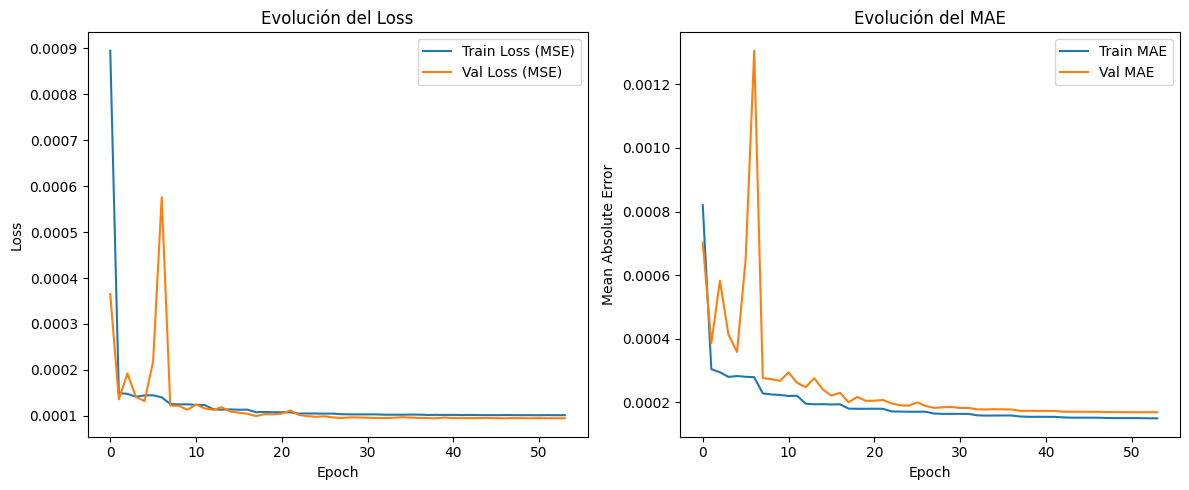

In [18]:
# -------------------------------
# Visualize the training process
# -------------------------------
plt.figure(figsize=(12, 5))

# Loss (MSE)
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Val Loss (MSE)')
plt.title("Evolución del Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# MAE (reconstruction error)
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title("Evolución del MAE")
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error")
plt.legend()

plt.tight_layout()
plt.show()

En la gráfica de Loss (MSE):

* Ambas curvas (entrenamiento y validación) convergen y se estabilizan mucho mejor
* Después del epoch 10-15, las curvas se vuelven muy estables y prácticamente idénticas
* El error final es aproximadamente 0.0001, mucho menor que en la arquitectura anterior


En la gráfica de MAE:

* Hay algunos picos iniciales de validación en los primeros 10 epochs
* Después de eso, las curvas se estabilizan y convergen muy bien
* Al final del entrenamiento, ambas métricas son muy similares y bajas

In [19]:
# Generate embeddings
embeddings = encoder.predict(X)

1976/1976 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [20]:
# Prepare DataFrame for insertion
df_embeddings = pd.DataFrame(embeddings, columns=[f"feat_{i}" for i in range(encoding_dim)])
df_embeddings["manga_id"] = df_features["manga_id"].values

In [21]:
for manga_id, embedding in zip(df_embeddings["manga_id"], embeddings):
    try:
        cur.execute("SELECT 1 FROM mangas_embeddings WHERE manga_id = %s", (int(manga_id),))
        exists = cur.fetchone() is not None
        
        if exists:
            cur.execute("""
                UPDATE mangas_embeddings
                SET embeddings_features = %s
                WHERE manga_id = %s
            """, (embedding.tolist(), int(manga_id)))
        else:
            cur.execute("""
                INSERT INTO mangas_embeddings (manga_id, embeddings_features)
                VALUES (%s, %s)
            """, (int(manga_id), embedding.tolist()))
            
        print(f"[OK] {'Updated' if exists else 'Inserted'} embedding for manga_id {manga_id}")
    except Exception as e:
        conn.rollback()  # 🔧 Esto permite continuar tras un error
        print(f"[ERROR] Could not process manga_id {manga_id}: {e}")

[OK] Updated embedding for manga_id 154975
[OK] Updated embedding for manga_id 154976
[OK] Updated embedding for manga_id 154977
[OK] Updated embedding for manga_id 154978
[OK] Updated embedding for manga_id 154979
[OK] Updated embedding for manga_id 154980
[OK] Updated embedding for manga_id 154981
[OK] Updated embedding for manga_id 154982
[OK] Updated embedding for manga_id 154983
[OK] Updated embedding for manga_id 166901
[OK] Updated embedding for manga_id 175906
[OK] Updated embedding for manga_id 175907
[OK] Updated embedding for manga_id 166902
[OK] Updated embedding for manga_id 166903
[OK] Updated embedding for manga_id 166904
[OK] Updated embedding for manga_id 166905
[OK] Updated embedding for manga_id 166906
[OK] Updated embedding for manga_id 166907
[OK] Updated embedding for manga_id 166908
[OK] Updated embedding for manga_id 166909
[OK] Updated embedding for manga_id 166910
[OK] Updated embedding for manga_id 166911
[OK] Updated embedding for manga_id 166912
[OK] Update

In [22]:
# Close the database connection
conn.commit()
cur.close()
conn.close()

In [ ]:
# Reconstruct input using the autoencoder
X_reconstructed = autoencoder.predict(X)

# Now compare X (original) vs X_reconstructed
mse = mean_squared_error(X, X_reconstructed)
print(f"\n🔍 Reconstruction Mean Squared Error (MSE): {mse:.6f}")

1976/1976 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step


KeyboardInterrupt: 

In [ ]:
# Visualize original vs reconstructed (first 5 samples)
num_samples = 5
plt.figure(figsize=(14, 8))

for i in range(num_samples):
    plt.subplot(num_samples, 2, 2*i+1)
    plt.plot(X[i], label='Original')
    plt.title(f"Original Sample {i}")
    plt.grid(True)

    plt.subplot(num_samples, 2, 2*i+2)
    plt.plot(embeddings[i], label='Reconstructed', color='orange')
    plt.title(f"Reconstructed Sample {i}")
    plt.grid(True)

plt.tight_layout()
plt.show()